Load necessary packages

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix


**Synthetic Dataset Generation**

In [3]:
def generate_custom_data(samples_per_class=180):
    np.random.seed(42)
    centers = [
        [1, 1],
        [4, 7],
        [8, 3],
        [3, 10],
        [9, 9]
    ]

    X_list = []
    y_list = []

    for class_idx, center in enumerate(centers):
        class_data = np.random.randn(samples_per_class, 2) * 0.9 + np.array(center)
        X_list.append(class_data)
        y_list += [class_idx] * samples_per_class

    X = np.vstack(X_list)
    y = np.array(y_list)

    return X, y

X, y = generate_custom_data()

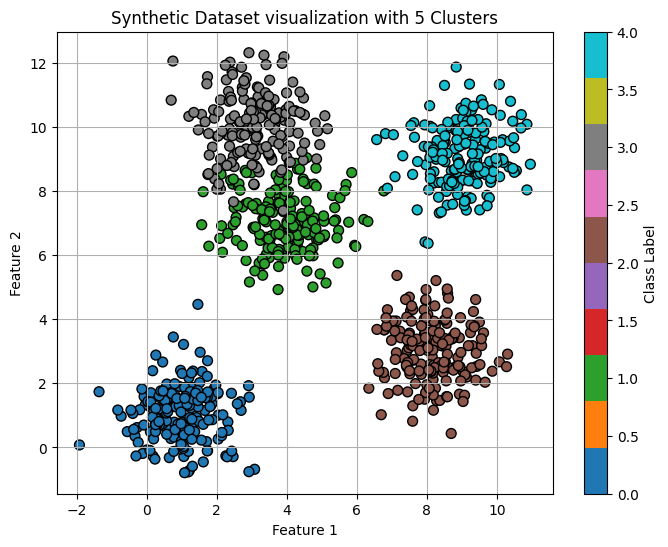

In [4]:
# Synthetic data visualization
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', edgecolor='k', s=50)
plt.title("Synthetic Dataset visualization with 5 Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Class Label')
plt.grid(True)
plt.show()



In [5]:
print("First 5 samples from dataset:")
print("X:", X[:5])
print("y:", y[:5])

First 5 samples from dataset:
X: [[1.44704274 0.87556213]
 [1.58291968 2.37072687]
 [0.78926196 0.78927674]
 [2.42129153 1.69069126]
 [0.57747305 1.48830404]]
y: [0 0 0 0 0]


In [6]:
# One-hot encode the labels for multi-class classification
ohe = OneHotEncoder(sparse_output=False)
y_encoded = ohe.fit_transform(y.reshape(-1, 1))

# Splitting dataset into Training(60%) and Temp(40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42, stratify=y)

#Splitting the Temp set into Validation(20%) and Test(20%) set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1))


Defining Neural Network

In [7]:
class NeuralNetwork:
    def __init__(self, input_size, hidden1, hidden2, hidden3, output_size, learning_rate=0.01):
        self.lr = learning_rate
        self.W1 = np.random.randn(input_size, hidden1) * np.sqrt(1. / input_size)
        self.b1 = np.zeros((1, hidden1))
        self.W2 = np.random.randn(hidden1, hidden2) * np.sqrt(1. / input_size)
        self.b2 = np.zeros((1, hidden2))
        self.W3 = np.random.randn(hidden2, hidden3) * np.sqrt(1. / input_size)
        self.b3 = np.zeros((1, hidden3))
        self.W4 = np.random.randn(hidden3, output_size) * np.sqrt(1. / input_size)
        self.b4 = np.zeros((1, output_size))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.sigmoid(self.Z2)
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.sigmoid(self.Z3)
        self.Z4 = np.dot(self.A3, self.W4) + self.b4
        self.output = self.softmax(self.Z4)
        return self.output

    def compute_loss(self, Y, Y_hat):
        m = Y.shape[0]
        loss = -np.sum(Y * np.log(Y_hat + 1e-8)) / m
        return loss

    def backward(self, X, Y):
        m = Y.shape[0]

        dZ4 = self.output - Y
        dW4 = np.dot(self.A3.T, dZ4) / m
        db4 = np.sum(dZ4, axis=0, keepdims=True) / m

        dA3 = np.dot(dZ4, self.W4.T)
        dZ3 = dA3 * self.sigmoid_derivative(self.A3)
        dW3 = np.dot(self.A2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m

        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.sigmoid_derivative(self.A2)
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.sigmoid_derivative(self.A1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1


Training Model

In [8]:
# Training
nn = NeuralNetwork(input_size=2, hidden1=32, hidden2=32, hidden3=32, output_size=5, learning_rate=0.001)
epochs = 1000
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    output = nn.forward(X_train)
    train_loss = nn.compute_loss(y_train, output)
    train_losses.append(train_loss)
    train_pred = np.argmax(output, axis=1)
    train_true = np.argmax(y_train, axis=1)
    train_acc = accuracy_score(train_true, train_pred)
    train_accuracies.append(train_acc)

    nn.backward(X_train, y_train)

    val_output = nn.forward(X_val)
    val_loss = nn.compute_loss(y_val, val_output)
    val_losses.append(val_loss)
    val_pred = np.argmax(val_output, axis=1)
    val_true = np.argmax(y_val, axis=1)
    val_acc = accuracy_score(val_true, val_pred)
    val_accuracies.append(val_acc)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")


Epoch 0: Train Loss = 3.6928, Val Loss = 3.6888, Train Acc = 0.2000, Val Acc = 0.2000
Epoch 100: Train Loss = 3.0229, Val Loss = 3.0218, Train Acc = 0.2000, Val Acc = 0.2000
Epoch 200: Train Loss = 2.6215, Val Loss = 2.6211, Train Acc = 0.2000, Val Acc = 0.2000
Epoch 300: Train Loss = 2.3153, Val Loss = 2.3152, Train Acc = 0.2000, Val Acc = 0.2000
Epoch 400: Train Loss = 2.0841, Val Loss = 2.0844, Train Acc = 0.2000, Val Acc = 0.2000
Epoch 500: Train Loss = 1.9184, Val Loss = 1.9189, Train Acc = 0.2000, Val Acc = 0.2000
Epoch 600: Train Loss = 1.7965, Val Loss = 1.7971, Train Acc = 0.2278, Val Acc = 0.2222
Epoch 700: Train Loss = 1.7003, Val Loss = 1.7008, Train Acc = 0.2926, Val Acc = 0.3222
Epoch 800: Train Loss = 1.6208, Val Loss = 1.6212, Train Acc = 0.5667, Val Acc = 0.5722
Epoch 900: Train Loss = 1.5547, Val Loss = 1.5549, Train Acc = 0.5704, Val Acc = 0.5722


Testing Model

In [9]:
test_output = nn.forward(X_test)
test_pred = np.argmax(test_output, axis=1)
test_true = np.argmax(y_test, axis=1)
test_acc = accuracy_score(test_true, test_pred)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Test Accuracy: 55.56%


Loss and Accuracy Visualization

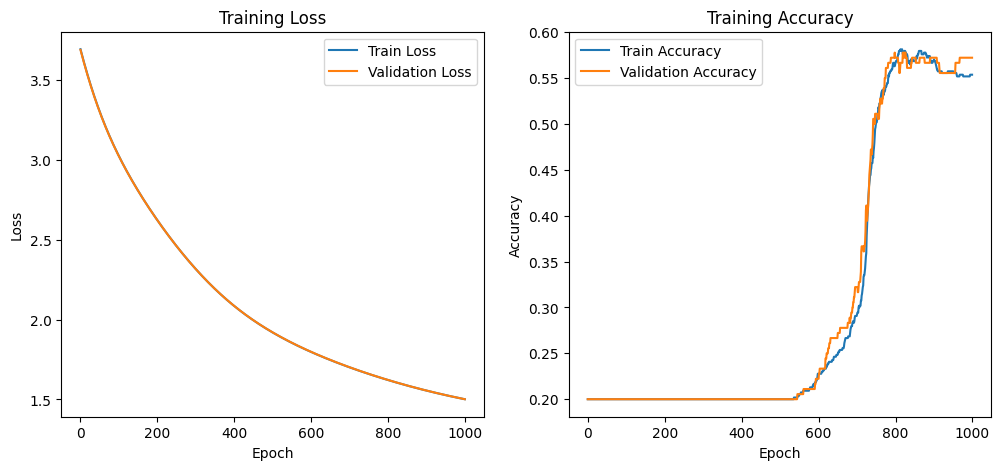

In [10]:

# Plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


The first graph displays training and validation loss across 1000 epochs. The loss is initially large (about 0.45), but it gradually decreases, indicating that the model is learning. However, the loss remains somewhat high even after training, indicating that the model is not doing a good job of fitting the data.

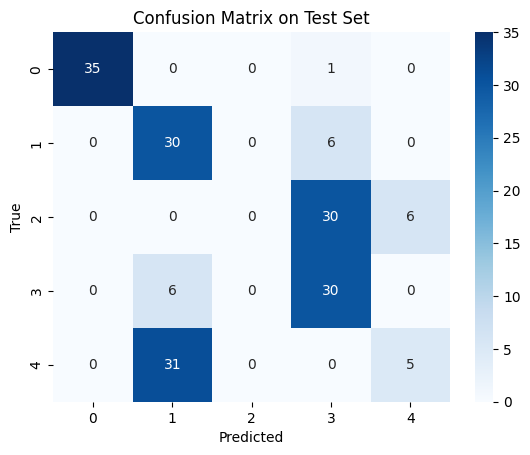

In [19]:
# Confusion Matrix
cm = confusion_matrix(test_true, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()

**Documentation:**
The provided code was modified to implement a three-hidden-layer neural network for multi-class classification using synthetic data. A dataset with 900 samples (180 for each class) was generated. The hidden layer  was expanded to three layers, where each layer containing 32 neurons, and in the output layer 5 neurons were used to represent the five classes. Sigmoid activation functions were used in the hidden layers and the output layer was replaced with softmax to handle multi-class predictions. The provided codebase used mean squared error (MSE), which is suitable for binary classification.It was replaced with categorical cross-entropy loss, which is more appropriate for comparing predicted probability distributions with one-hot encoded labels. The dataset was split into training, validation, and test sets. Proper evaluation was conducted using accuracy metrics, loss curves, classification reports, and a confusion matrix.


**Conclusion:**
The model's accuracy gradually improved over the training process. At the beginning (epoch 0 to 500), the accuracy was very low(20%), which means the model was  predicting randomly among the five classes.After 600 epochs the accuracy slowly increased.Both training and validation accuracy reached around 57% at 800 epoch.That indicated the model had started learning the patterns. However, after completing 1000 epochs, the final test accuracy was reached to **55.56%**, which is  slightly better than random guessing.This suggests that even if the model gained knowledge, its functionality is still limited.
The model's faced several challenges during implementation.One challenge was getting the one-hot encoding of labels right and making sure the output shape matched during training. This caused some errors that had to be fixed. Also, to get better accuracy and smooth training, the learning rate and the size of hidden layers had to be adjusted by trying different values.
To improve the neural network’s performance,using ReLU activation function instead of sigmoid can speed up learning and avoid gradient issues. Changing the optimizer to Adam can help the model train better.